# 1_Download_email note
- 这些函数不一定对大家都适用，因为html结构不同。所以如果用不了的话，只能自己inspect然后一个一个节点找了。gmail在download前先在gmail的页面gear-setting-conversation view off，目的是一个row只对应一封邮件。为了数据统一好处理，建议大家最后download的结果都是做成[(email,name,title,content,date)]这样的格式。

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"       
import time 
import requests 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from bs4 import BeautifulSoup     
from urllib.request import urlopen
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
#这个函数用于直接从gmail登录学校邮箱,如果绑定的是Outlook可能不适用
def login(driver,user,pwd, user_stevens='zwang173'): 
    driver.get('https://gmail.com/')
    driver.find_element_by_id('identifierId').send_keys(user)
    driver.find_element_by_xpath("//div[@id='identifierNext']/content/span").click()
    driver.switch_to.window(driver.window_handles[0])
    time.sleep(2)
    driver.find_element_by_id("username").send_keys(user_stevens)
    driver.find_element_by_id("password").send_keys(pwd)
    driver.find_element_by_name("_eventId_proceed").click()
    driver.switch_to.window(driver.window_handles[0])
    time.sleep(2)
    driver.find_element_by_xpath("//div[@id='view_container']/descendant::content/span").click()
    driver.switch_to.window(driver.window_handles[0])
    return driver

In [3]:
#这个函数直接用于登录gmail,其他邮箱可能不适用
def login_gmail(driver,user,pwd):    
    driver.get('https://gmail.com/')
    driver.find_element_by_id('identifierId').send_keys(user)
    driver.find_element_by_xpath("//div[@id='identifierNext']/content/span").click()
    time.sleep(2)
    driver.find_element_by_name('password').send_keys(pwd)
    driver.find_element_by_xpath("//div[@id='passwordNext']/content/span").click()
    return driver

In [4]:
#这个函数用于提取邮件的邮件域，标题，内容及时间，spam若为true则提取垃圾邮件反之提取正常邮件
#函数有可能出现卡顿或报错，可以试着用time.sleep()解决，或者多运行几遍(测试了很多遍，报错多运行几遍一定可以解决)
#我不确定每个人的gmail的html是否都相同，若有不同只需要改其中的id或者class，其他邮箱可能要改结构
#该结构的话尽量不要改iframe，邮箱通常会拒绝访问
#提取的结果为list，其中元素为tuple
def get_data(driver,spam=False):
    time.sleep(1)
    row = []
    n = 0
    
    if spam == True:
        time.sleep(3)
        driver.find_element_by_xpath("//div[@class='wT']/div[@class='n6']/span/span").click()
        driver.find_element_by_xpath("//div[@class='TN bzz aHS-bnv']/div/span").click()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        total_num = int([i.get_text() for i in soup.select('div#:zm span.ts')][-1].replace(',',''))
        page_number = int(total_num / 50)
        time.sleep(2)
    else:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        total_num = int([i.get_text() for i in soup.select('div#:hh span.ts')][-1].replace(',',''))
        page_number = int(total_num / 50)
        time.sleep(2)

    while n <= page_number: 
        lst = []
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        for tr in tbody:
            name = None
            email= None
            title = None
            date = None
            
            td_sender = tr.select('td.yX.xY span.bA4')[0].select_one('span')
            if td_sender != []:
                email = td_sender.attrs['email']
                name = td_sender.attrs['name']           

            td_title = tr.select('td.xY.a4W span.bog')
            if td_title != []:
                title = td_title[0].get_text()

            td_content = tr.select('td.xY.a4W span.y2')
            if td_content != []:
                content = td_content[0].get_text()
            
            td_date = tr.select('td.xW.xY span')
            if td_date != []:
                date = td_date[0].get_text()   
            
            lst.append((email,name,title,content,date))
        
        if n == 0:
            row = lst[-50:]
        elif n == page_number:
            row += lst[-(total_num-page_number*50):] 
        else:
            row += lst[-50:] 
              
        id_click = soup.select('div.ar5.J-J5-Ji span.Di div')[-1].attrs['id']
        time.sleep(2)
        
        if n < page_number:
            driver.find_element_by_id(id_click).click()
            driver.switch_to.window(driver.window_handles[0])
            time.sleep(1)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        n += 1
        time.sleep(1)
    
    driver.quit()
    return row

In [5]:
#获取全部content，num为获取邮件数量，获取过程中会有重复获取，lst_num中储存了重复值的索引
def get_content(driver, num, spam=False):
    n = 0;
    lst = []
    lst_num = []
    if spam == True:
        time.sleep(3)
        driver.find_element_by_xpath("//div[@class='wT']/div[@class='n6']/span/span").click()
        driver.find_element_by_xpath("//div[@class='TN bzz aHS-bnv']/div/span").click()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        total_num = int([i.get_text() for i in soup.select('div#:zm span.ts')][-1].replace(',',''))
        driver.find_element_by_xpath("//table[@id=':k5']/tbody/tr").click()
    else:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        total_num = int([i.get_text() for i in soup.select('div#:hh span.ts')][-1].replace(',',''))
        driver.find_element_by_xpath("//table[@id=':20']/tbody/tr").click()  
        time.sleep(2)    
        
    driver.switch_to.window(driver.window_handles[0])
   
    while n < num:       
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        lst_num.append(int([i.get_text() for i in soup.select('div.h0 span.ts')][0].replace(',','')))
        lst.append(soup.select('div.G3.G2 div.gs div.ii.gt')[0].get_text())
        if total_num <= n + 1:
            break
        while(True):
            try:            
                driver.find_element_by_xpath("//div[@class='T-I J-J5-Ji adg T-I-awG T-I-ax7 T-I-Js-Gs L3']").click()             
                break
            except:
                continue   
        n += 1
        time.sleep(1)
    
    driver.quit()
    return lst,lst_num

In [7]:
#获取spam基本信息
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
data_s = get_data(driver,spam=True)
data_s_copy = data_s

In [12]:
#获取spam全部文字内容
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
driver.switch_to.window(driver.window_handles[0])
data_content_s = get_content(driver, 199, spam=True)
data_content_s_copy = data_content_s

In [51]:
#获取ham基本信息
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
data_h = get_data(driver,spam=False)
data_h_copy = data_h

In [57]:
#获取ham全部文字内容
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
driver.switch_to.window(driver.window_handles[0])
data_content_h = get_content(driver, 1000, spam=False)
data_content_h_copy = data_content_h 

In [87]:
df_content_h = pd.DataFrame(data_content_h[0],columns = ['content'])
duplicate = list(set([i for i in data_content_h[1] if data_content_h[1].count(i) > 1]))
df_content_h = df_content_h.drop(duplicate)
df_h = pd.DataFrame(data_h,columns = ['address','name','title','content','date'])
df_h['spam'] = np.zeros(len(data_h),int)
df_h.index = np.arange(len(df_h))
df_h.index.name = 'index'
df_h = df_h.drop(duplicate)
id = [i for i,j in zip(df_content_h.index,df_h.index) if i == j]
df_h = df_h.loc[id,:]
df_h.content = df_content_h.content 

In [108]:
df_content_s = pd.DataFrame(data_content_s[0],columns = ['content'])
duplicate = list(set([i for i in data_content_s[1] if data_content_s[1].count(i) > 1]))
df_content_s = df_content_s.drop(duplicate)
df_s = pd.DataFrame(data_s,columns = ['address','name','title','content','date'])
df_s['spam'] = np.ones(len(data_s),int)
df_s.index = np.arange(len(df_s))
df_s.index.name = 'index'
df_s = df_s.drop(duplicate)
id = [i for i,j in zip(df_content_s.index,df_s.index) if i == j]
df_s = df_s.loc[id,:]
df_s.content = df_content_s.content    

In [110]:
#合并dataset
df = df_h.append(df_s, ignore_index=True)
df.index = np.arange(len(df))
df.index.name = 'index'

In [146]:
#导出csv
df_zrm.to_csv(r'C:\Users\wzxwa\Desktop\660\data\df_zrm.csv')

In [3]:
df_wzx = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_wzx.csv').set_index('index')
df_jsj = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_jsj.csv').set_index('index')
df_zrm = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_zrm.csv',encoding='latin-1').set_index('index')

In [3]:
df = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\df_wzx.csv').set_index('index')

In [142]:
df_wzx['content'] = [re.sub(r'\s+', ' ', \
                            re.compile("[^\u4e00-\u9fa5^.^,^-^'^:^/^?^!^$^%^a-z^A-Z^0-9^]").sub(" ", i)) \
                     for i in df_wzx.content]

In [250]:
df = df_wzx.append(df_jsj.append(df_zrm, ignore_index=True), ignore_index=True)
df.index = np.arange(len(df))
df.index.name = 'index'

In [252]:
df.to_csv(r'C:\Users\wzxwa\Desktop\660\df_all.csv')

In [ ]:
df_j_spam = df_jsj.iloc[-50:,].content
df_w_spam = df_wzx.iloc[-50:,].content
df_j_spam.index = np.arange(len(df_j_spam))
df_w_spam.index = np.arange(len(df_w_spam))
df_spam = pd.concat([df_w_spam, df_j_spam], axis=1 , join_axes=[df_w_spam.index])
df_spam.columns = ['content_w', 'content_j']

In [425]:
df = df.drop(df[df.content.isnull() == True].index,axis=0)

In [141]:
df_wzx = df_wzx.drop([473, 594])

In [11]:
tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm= tfidf_vect.fit_transform(df['content'])

# 2_Text_processing note
- 对text进行分割，处理无意义的字符，形成词袋和样本的特征向量，考虑特征向量矩阵过于稀疏，可能要PCA或者SVD降维

In [32]:
import string
import random
import os
import re
import nltk
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud


In [8]:
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [4]:
# def tokenize(text, lemma = False, stopword = False):
#     list_voc  = []
#     stop = set(stopwords.words('english'))
#     text = text.replace('\xa0-\xa0', ' ').replace('\u200c', ' ').replace("“", '').replace("”", '')
#     list_str = nltk.word_tokenize(text.lower())
#     if stopword == True:
#         list_voc = [i for i in list_str if i not in stop and i not in string.punctuation]
#     else:
#         list_voc = [i for i in list_str if i not in string.punctuation]      
#     if lemma == True:
#         nlp = en_core_web_sm.load()
#         list_join = " ".join(list_voc)
#         list_voc = [i.lemma_ for i in nlp(list_join)]
#     return list_voc

In [33]:
#处理字符串
def tokenize(text, lemma = False, stopword = False):
    list_voc  = []
    stop = set(stopwords.words('english'))
    text = re.sub(r'[(\.\xa0)(\.\u200c)(\.\n)(\.\t)(\.\r)]',' ',text)
    list_str = nltk.word_tokenize(text)
    for i in list_str:
        i = i.strip(string.punctuation).lower()   
        list_voc.append(i) 
    if stopword == True:
        list_voc = [i for i in list_voc if i not in stop and i not in string.punctuation]
    else:
        list_voc = [i for i in list_voc if i not in string.punctuation]      
    if lemma == True:
        nlp = spacy.load('en')
        list_join = " ".join(list_voc)
        list_voc = [i.lemma_ for i in nlp(list_join)]
    list_voc=list(filter(None, list_voc))
    return list_voc

In [14]:
# #处理字符串
# def tokenize(s):
#     list_voc  =[]
#     stop = set(stopwords.words('english'))
#     s = s.replace('\n',' ').replace('\t',' ').replace('\xa0','').replace("“",'').replace("”",'')
#     list_str = s.lower().split(' ')
#     for i in list_str:
#         i = i.strip(string.punctuation)
#         if i not in stop and i not in string.punctuation:    
#             list_voc.append(i)
#     list_voc=list(filter(None, list_voc)) 
#     return list_voc

In [15]:
#将字符串装入list
def text_lst(data, lemma = False, stopword = False):    
    text = []
    for x in data:
        text += tokenize(x, lemma, stopword)
    return text

In [16]:
#统计词频
def count(lst,dic=None):
    if dic is None:
        dic = {}
    for x in lst:
        if x in dic:
            dic[x] += 1
        else:
            dic[x] = 1
    return dic

In [17]:
#按词频排序
def sort_word(sort_dic, spam = 'All'):
    dic = {}
    if spam == 'All':
        for i in sort_dic.items():
            dic.setdefault(i[0],np.sum(list(i[1].values())))
    elif spam == True:    
        for i in word_catogory.items():
            dic.setdefault(i[0],list(i[1].values())[0])
    elif spam == False:
        for i in word_catogory.items():
            dic.setdefault(i[0],list(i[1].values())[1])
    return sorted(dic.items(),key=lambda item:item[1],reverse=1)  

In [18]:
#n-gram,暂时不用
def ngrams(lst, n):
    lst_n = []
    for i in range(len(lst)-n+1):
        lst_n.append(lst[i:i+n])
    return lst_n

In [19]:
#比较某词在spam和ham中出现的次数
def catogory_count(count_spam_keys,count_spam_values,count_ham_keys,count_ham_values):
    dic = {}
    for i,j in zip(list(count_spam_keys),list(count_spam_values)):
        dic.setdefault(i,{})
        dic[i].setdefault('spam',j)
        dic[i].setdefault('ham',0)
    for i,j in zip(list(count_ham_keys),list(count_ham_values)):
        if i in list(dic.keys()):
            dic[i]['ham'] = j 
        else:
            dic.setdefault(i,{})
            dic[i].setdefault('spam',0)
            dic[i]['ham'] = j 
    return dic

In [20]:
#将text转换成数值向量，核心操作
def create_vectors(list_uni,key):
    vectors = []
    for i in range(len(list_uni)):
        dic = dict.fromkeys(key, 0)
        vectors.append(np.array(list(count(list_uni[i],dic).values())))
    return np.array(vectors)

In [21]:
#将词频数值向量准换成tf-idf矩阵
def analyze_tf_idf(array):
    tf_idf = None
    tf = array
    idf = np.log(len(array) / (np.sum(np.where(array!=0,1,0),axis=0) + 1)) + 1
    tf_idf = tf * idf[None,:]
    return tf_idf   

In [22]:
#考虑到矩阵稀疏，降维后观察分类情况
def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['Orange','Blue']
    l_0 = []
    l_1 = []
    l_test = []
    l1_index = [list(lsa_scores[:,0]).index(i) for i in lsa_scores[:,0] ]
    for i in l1_index:
        l_0.append(list(lsa_scores[:,0])[i])
        l_1.append(list(lsa_scores[:,1])[i])
        l_test.append(list(test_labels)[i])
    plt.scatter(l_0, l_1, s=8, alpha=.8, c=l_test, cmap=matplotlib.colors.ListedColormap(colors))
    ham_patch = mpatches.Patch(color='orange', label='Ham')
    spam_patch = mpatches.Patch(color='blue', label='Spam')
    plt.legend(handles=[ham_patch, spam_patch], prop={'size': 20})

In [23]:
def get_similarity(df,col1,col2,lemma = False, stopword = False):
    docs_tokens = {idx:nltk.FreqDist(tokenize(doc, lemma, stopword)) \
             for idx,doc in enumerate(list(df[col1]))}
    dtm1 = pd.DataFrame.from_dict(docs_tokens, \
                               orient="index" ).fillna(0)
    docs_tokens = {idx:nltk.FreqDist(tokenize(doc, lemma, stopword)) \
             for idx,doc in enumerate(list(df[col2]))}
    dtm2 = pd.DataFrame.from_dict(docs_tokens, \
                               orient="index" ).fillna(0)
    dtm = dtm1.append(dtm2, ignore_index=True).fillna(0)
    
    tf_idf = analyze_tf_idf(np.array(dtm))
    
    similarity_list = [1 - float(distance.pdist([tf_idf[i],tf_idf[int(len(tf_idf)/2+i)]], 'cosine')) \
                       for i in range(int(len(tf_idf)/2))]
    return similarity_list

In [16]:
# def text_lst(data):    
#     text = []
#     for x in data:
#         text += tokenize(x)
#     return text

# def count(lst,dic=None):
#     if dic is None:
#         dic = {}
#     for x in lst:
#         if x in dic:
#             dic[x] += 1
#         else:
#             dic[x] = 1
#     return dic

# def create_vectors(list_uni,key):
#     vectors = []
#     for i in range(len(list_uni)):
#         dic = dict.fromkeys(key, 0)
#         vectors.append(np.array(list(count(list_uni[i],dic).values())))
#     return np.array(vectors)

# def get_similarity(df,col1,col2,lemma = False, stopword = False):
#     list_total = [i + " " + j for i,j in zip(list(df[col1]),list(df[col2]))]
#     data1 = list(df[col1])
#     data2 = list(df[col2])
#     sample1 = [tokenize(i) for i in data1]
#     sample2 = [tokenize(i) for i in data2]
#     word1 = text_lst(data1)
#     word2 = text_lst(data2)
#     count1 = count(word1)
#     count2 = count(word2)
#     bag_of_word = list(set(list(count1.keys())+list(count2.keys())))
#     freq_vec1 = create_vectors(sample1,key=bag_of_word)
#     freq_vec2 = create_vectors(sample2,key=bag_of_word)
#     tf1 = freq_vec_1
#     idf1 = np.log(len(tf1) / (np.sum(np.where(tf1!=0,1,0),axis=1) + 1)) 
#     tf_idf_1 = tf1 * idf1[:,None]
#     tf2 = freq_vec_2
#     idf2 = np.log(len(tf2) / (np.sum(np.where(tf2!=0,1,0),axis=1) + 1)) 
#     tf_idf_2 = tf2 * idf2[:,None]
#     similarity_list = [1 - float(distance.pdist([tf_idf_1[i],tf_idf_2[i]], 'cosine')) for i in range(len(tf_idf_1))]
#     return similarity_list

In [47]:
#Compare the similarity among different people
similarity_list_s = get_similarity(df_spam,'content_w','content_j',lemma = False, stopword = True)
similarity_list_s

NameError: name 'df_spam' is not defined

In [158]:
for i in df_spam['content'].index:
    df_spam.loc[i,'content'] = ' '.join(tokenize(df_spam.loc[i,'content']))

In [140]:
df_ham.loc[4,'title'] = ' '.join(tokenize(df_ham.loc[4,'title']))

In [79]:

df_spam

,address,name,title,content,date,spam,suffix
index,,,,,,,
1001,clinique@e.clinique.com,Clinique Online,Fresh Face Kit FREE with purchase.,These are the Skills of T morrow The first ev...,28-Mar,1,@e.clinique.com
1002,Bloomingdales@e.bloomingdales.com,Bloomingdale's,16 hours only! Save 50-70% on fine jewelry,A Nanny Match has an opportunity for you! 1 n...,26-Mar,1,@e.bloomingdales.com
1003,mollymail@shein.com,SHEIN,Level Up: Free Shipping Sitewide! + Buy 3 Get ...,Free kits with purchase. View in browser Unsu...,10-Mar,1,@shein.com
1004,MACOnlineService@maccosmetics.com,MACOnlineService,Your M_A_C Cosmetics Order 3537880202 has shipped,Free makeup kit with purchase. View in browse...,26-Mar,1,@maccosmetics.com
1005,Bloomingdales@e.bloomingdales.com,Beauty at Bloomingd.,"Buy more, save more in beauty",Free moisturizer duo with purchase. View in b...,26-Mar,1,@e.bloomingdales.com
1006,belk@belkemail.com,Belk,Welcome Home to Unparalleled Luxury,Free moisturizer duo with purchase. View in b...,26-Mar,1,@belkemail.com
1007,caja_lg@stanzione.com,UPS US,Tracking Number 4ALN14645389116562,Today Only! Our favorite holiday offers are b...,11-Mar,1,@stanzione.com
1008,ExamReview@surgent.com,Surgent Exam Review,A review of the top 5 accounting certifications,You shop it. We ship it. View in browser Unsu...,12-Mar,1,@surgent.com
1009,slld@kean.edu,Kean University,The Cougar's Byte - Byte Size Edition - March ...,30% off in store EXTRA 10% View online Suppor...,4-Mar,1,@kean.edu


## note
- 以下部分是用上面的函数对text做了一些简要处理，后面可以考虑用nltk重新做处理，但目前这个pkg以及正则我也不是很熟悉的小伙伴可以助攻一波。还有就是bigram或者句子的问题，我感觉我们可以先做word，然后得到看得过去的结果后再考虑ngram或者语义分析

In [9]:
df = pd.read_csv('hamspam.csv',encoding ='latin1').set_index('index')
df['suffix'] = [re.findall(r'@[\w.|-]+',i)[0] for i in df.address]

In [122]:
print(df['suffix'])

index
1             @online.costco.com
2               @n.skinstore.com
3           @e.bloomingdales.com
4            @e.maccosmetics.com
5               @focuscamera.com
6           @e.bloomingdales.com
7          @surgentcpareview.com
8               @n.skinstore.com
9            @ep.coachoutlet.com
10              @n.skinstore.com
11           @ep.coachoutlet.com
12                   @indeed.com
13          @e.bloomingdales.com
14               @e.clinique.com
15                @belkemail.com
16              @n.skinstore.com
17          @e.bloomingdales.com
18           @e.maccosmetics.com
19           @e.maccosmetics.com
20              @n.skinstore.com
21                @belkemail.com
22            @connect.miami.edu
23              @n.skinstore.com
24          @e.bloomingdales.com
25          @e.bloomingdales.com
26               @e.clinique.com
27           @e.maccosmetics.com
28             @maccosmetics.com
29           @e.maccosmetics.com
30          @e.bloomingdales.com
    


LDA Classifier


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.8659

LR Classifier
0.9562499999999999
0.9562

SVM Classifier


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9485

NB Classifier
0.8933


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

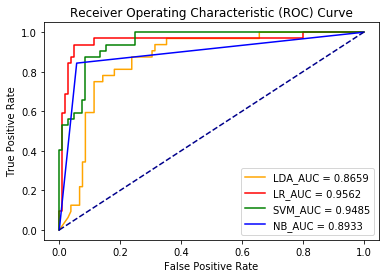

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9343065693430657
0.9657738095238095
0.9658


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

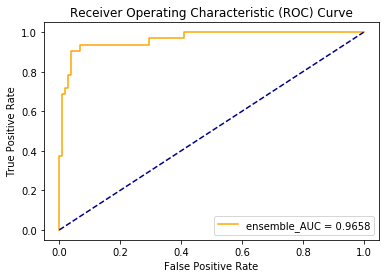

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X_text, y_label, test_size=0.25, random_state=0)

LDA = LinearDiscriminantAnalysis()
LR = LogisticRegression()
KNN = KNeighborsClassifier()
NB = GaussianNB()


# LDA
print('\nLDA Classifier')
LDA = LinearDiscriminantAnalysis()
LDA = LDA.fit(X_train, y_train)
LDA_score = LDA.score(X_test, y_test)
# print(LDA_score)
LDA_probs = LDA.predict_proba(X_test)
LDA_probs = LDA_probs[:, 1]
LDA_auc = roc_auc_score(y_test, LDA_probs)
LDA_auc = round(LDA_auc, 4)
print(LDA_auc)

LDA_fpr, LDA_tpr, thresholds = roc_curve(y_test, LDA_probs, pos_label=1)


# LR
print('\nLR Classifier')
LR = LogisticRegression(solver='lbfgs', max_iter=5000)
LR = LR.fit(X_train, y_train)
LR_score = LR.score(X_test, y_test)
# print(LR_score)
LR_probs = LR.predict_proba(X_test)
LR_probs = LR_probs[:, 1]
# print(probs)
LR_auc = roc_auc_score(y_test, LR_probs)
print(LR_auc)
LR_auc = round(LR_auc, 4)
print(LR_auc)

LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR_probs, pos_label=1)


# SVM
print('\nSVM Classifier')
SVM = svm.SVC(kernel='rbf', probability=True)
SVM = SVM.fit(X_train, y_train)
SVM_score = SVM.score(X_test, y_test)
# print(SVM_score)
SVM_probs = SVM.predict_proba(X_test)
SVM_probs = SVM_probs[:, 1]
# print(SVM_probs)
SVM_auc = roc_auc_score(y_test, SVM_probs)
SVM_auc = round(SVM_auc, 4)
print(SVM_auc)

SVM_fpr, SVM_tpr, thresholds = roc_curve(y_test, SVM_probs, pos_label=1)


# NB
print('\nNB Classifier')
NB = GaussianNB()
NB = NB.fit(X_train, y_train)
NB_score = NB.score(X_test, y_test)
# print(NB_score)
NB_probs = NB.predict_proba(X_test)
NB_probs = NB_probs[:, 1]
# print(NB_probs)
NB_auc = roc_auc_score(y_test, NB_probs)
NB_auc = round(NB_auc, 4)
print(NB_auc)

NB_fpr, NB_tpr, thresholds = roc_curve(y_test, NB_probs, pos_label=1)

# models plot
plt.plot(LDA_fpr, LDA_tpr, color='orange', label='LDA_AUC = {}'.format(LDA_auc))
plt.plot(LR_fpr, LR_tpr, color='red', label='LR_AUC = {}'.format(LR_auc))
plt.plot(SVM_fpr, SVM_tpr, color='green', label='SVM_AUC = {}'.format(SVM_auc))
plt.plot(NB_fpr, NB_tpr, color='blue', label='NB_AUC = {}'.format(NB_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Ensemble
print('\n\n')
estimator = [('NB', NB), ('LR', LR), ('LDA', LDA), ('SVM', SVM)]
ensemble = VotingClassifier(estimator, voting='soft')
ensemble = ensemble.fit(X_train, y_train)
ensemble_score = ensemble.score(X_test, y_test)
print(ensemble_score)
ensemble_probs = ensemble.predict_proba(X_test)
ensemble_probs = ensemble_probs[:, 1]
# print(NB_probs)
ensemble_auc = roc_auc_score(y_test, ensemble_probs)
print(ensemble_auc)
ensemble_auc = round(ensemble_auc, 4)
print(ensemble_auc)

ensemble_fpr, ensemble_tpr, thresholds = roc_curve(y_test, ensemble_probs, pos_label=1)

# ensemble model plot
plt.plot(ensemble_fpr, ensemble_tpr, color='orange', label='ensemble_AUC = {}'.format(ensemble_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()







In [92]:
idx_rdm_ham = random.sample(list(df[df.spam == 0].index),400)
idx_rdm_ham.sort()
df_ham = df.loc[idx_rdm_ham,]
df_spam = df[df.spam == 1]
data_title_s = list(df_spam[df_spam.spam == 1].title)
data_content_s = list(df_spam[df_spam.spam == 1].content)
data_title_h = list(df_ham[df_ham.spam == 0].title)
data_content_h = list(df_ham[df_ham.spam == 0].content)
# data_title_s = [x[2] for x in data_s]
# data_content_s = [x[3] for x in data_s]
# data_title_h = [x[2] for x in data_h]
# data_content_h = [x[3] for x in data_h]
# data_s = [x + ' ' + y for x,y in zip(data_title_s,data_content_s)]
# data_h = [x + ' ' + y for x,y in zip(data_title_h,data_content_h)]
sample_content_s = [tokenize(str(x),lemma = False, stopword = True) for x in data_content_s]
sample_content_h = [tokenize(str(x),lemma = False, stopword = True) for x in data_content_h]
sample_title_s = [tokenize(str(x),lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(str(x),lemma = False, stopword = True) for x in data_title_h]
sample_s = [x + y for x,y in zip(sample_title_s,sample_content_s)]
sample_h = [x + y for x,y in zip(sample_title_h,sample_content_h)]
data_s = [' '.join(i) for i in sample_s]
data_h = [' '.join(i) for i in sample_h]
text_spam = ' '.join([' '.join(i) for i in sample_s])
text_ham = ' '.join([' '.join(i) for i in sample_h])
# title_word_s = text_lst(data_title_s)
# content_word_s = text_lst(data_content_s)
# title_word_h = text_lst(data_title_h)
# content_word_h = text_lst(data_content_h)
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
# title_count_s = count(title_word_s)
# content_count_s = count(content_word_s)
# title_count_h = count(title_word_h)
# content_count_h = count(content_word_h)
count_s = count(word_s)
count_h = count(word_h)

In [82]:
######classification####
sample_title_s = [tokenize(str(x),lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(str(x),lemma = False, stopword = True) for x in data_title_h]
data_title_s = [' '.join(i) for i in sample_title_s]
data_title_h = [' '.join(i) for i in sample_title_h]
text_title_spam = ' '.join([' '.join(i) for i in sample_title_s])
text_title_ham = ' '.join([' '.join(i) for i in sample_title_h])

word_title_s = text_lst(data_title_s, lemma = False, stopword = True)
word_title_h = text_lst(data_title_h, lemma = False, stopword = True)

count_title_s = count(word_title_s)
count_title_h = count(word_title_h)

In [90]:
bag_title_word_con = list(set(list(count_title_s.keys())+list(count_title_h.keys())))
freq_vec_title_s = create_vectors(sample_title_s,key=bag_title_word_con)
freq_vec_title_h = create_vectors(sample_title_h,key=bag_title_word_con)
tfidf_vec_title_s = analyze_tf_idf(freq_vec_title_s)
tfidf_vec_title_h = analyze_tf_idf(freq_vec_title_h)
tfidf_vec_title_s[0]
df_vec_title_s = pd.DataFrame(tfidf_vec_title_s)
df_vec_title_s['spam/ham'] = 1
df_vec_title_h = pd.DataFrame(tfidf_vec_title_h)
df_vec_title_h['spam/ham'] = 0
df_vec_title_s.columns = bag_title_word_con + ['spam/ham']
df_vec_title_h.columns = bag_title_word_con + ['spam/ham']

df_vec_title_conc = pd.concat([df_vec_title_s,df_vec_title_h])
df_vec_title_conc['ID'] = [i for i in range(1,len(df_vec_title_conc)+1)]
df_vec_title_conc = df_vec_title_conc.set_index('ID')


array([0., 0., 0., ..., 0., 0., 0.])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
labels:  [0, 1]
precision:  [0.91428571 0.525     ]
recall:  [0.77108434 0.77777778]
f-score:  [0.83660131 0.62686567]
support:  [83 27]
              precision    recall  f1-score   support

           0       0.91      0.77      0.84        83
           1       0.53      0.78      0.63        27

   micro avg       0.77      0.77      0.77       110
   macro avg       0.72      0.77      0.73       110
weighted avg       0.82      0.77      0.79       110



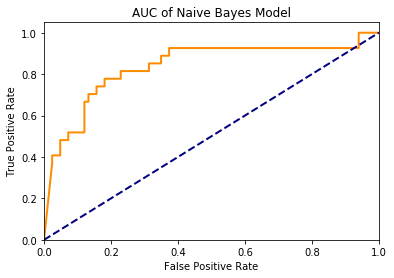

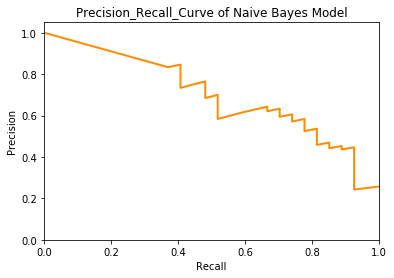

In [125]:
#####Navie Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

X_title_text = df_vec_title_conc.drop('spam/ham', axis=1).values
y_title_label = df_vec_title_conc.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(\
                X_title_text, y_title_label, test_size=0.2, random_state=0)

# train a multinomial naive Bayes model using the testing data
clf = MultinomialNB().fit(X_train, y_train)
print(clf)

predicted=clf.predict(X_test)


labels=sorted(df["spam"].unique())

precision, recall, fscore, support=\
     precision_recall_fscore_support(\
     y_test, predicted, labels=labels)

print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

# another way to get all performance metrics
print(classification_report(y_test, predicted, labels=labels))

# We need to get probabilities as predictions
predict_p=clf.predict_proba(X_test)

labels
# this label corresponds to last column
y_pred = predict_p[:,1]

# compute fpr/tpr by different thresholds
# positive class has label "1"
fpr, tpr, thresholds = roc_curve(y_test, y_pred, \
                                 pos_label=1)
# calculate auc
auc(fpr, tpr)
##plot:
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Naive Bayes Model');
plt.show();
# compute precision/recall by different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, \
                                y_pred, pos_label=1)

plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of Naive Bayes Model');
plt.show();

- Get the bag of words

In [118]:
####kmeans
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split
from nltk.cluster import KMeansClusterer,cosine_distance
from sklearn import metrics
num_clusters=2

clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=20)

clusters = clusterer.cluster(X_train,assign_clusters=True)

#print the cluster labels of the first 5 samples
print(clusters[0:5])
print(y_train[0:5])
predicted = [clusterer.classify(v) for v in X_test]
confusion_df = pd.DataFrame(list(zip(y_test, predicted)),\
                            columns = ["label", "cluster"])
confusion_df.head()
'''
# generate crosstab between clusters and true labels
pd.crosstab( index=confusion_df.cluster, columns=confusion_df.label)

cluster_dict={0:'1',\
              1:"0"}

# Map true label to cluster id
predicted_target=[cluster_dict[i] \
                  for i in predicted]

print(metrics.classification_report\
      (labels, predicted_target))
'''

[0, 0, 0, 1, 1]
[1 0 1 0 0]


,label,cluster
0,1,0
1,1,0
2,1,0
3,0,0
4,1,0


'\n# generate crosstab between clusters and true labels\npd.crosstab( index=confusion_df.cluster, columns=confusion_df.label)\n\ncluster_dict={0:\'1\',              1:"0"}\n\n# Map true label to cluster id\npredicted_target=[cluster_dict[i]                   for i in predicted]\n\nprint(metrics.classification_report      (labels, predicted_target))\n'

In [93]:
# bag_of_word = list(set(list(content_count_s.keys())+list(content_count_h.keys())))
bag_of_word_con = list(set(list(count_s.keys())+list(count_h.keys())))

In [94]:
len(bag_of_word_con)

8902

In [34]:
# freq_vec_content_s = create_vectors(sample_content_s,key=bag_of_word)
# freq_vec_content_h = create_vectors(sample_content_h,key=bag_of_word)

- frequency metrix

In [95]:
freq_vec_s = create_vectors(sample_s,key=bag_of_word_con)
freq_vec_h = create_vectors(sample_h,key=bag_of_word_con)

In [96]:
freq_vec_h[0]

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
# tfidf_vec_content_s = analyze_tf_idf(freq_vec_content_s)
# tfidf_vec_content_h = analyze_tf_idf(freq_vec_content_h)
# tfidf_vec_content_s[0]

- tf_idf metrix

In [98]:
tfidf_vec_s = analyze_tf_idf(freq_vec_s)
tfidf_vec_h = analyze_tf_idf(freq_vec_h)
tfidf_vec_s[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [99]:
# df_vec_content_s = pd.DataFrame(tfidf_vec_content_s)
# df_vec_content_s['spam/ham'] = 1
# df_vec_content_h = pd.DataFrame(tfidf_vec_content_h)
# df_vec_content_h['spam/ham'] = 0
# df_vec_content_s.columns = bag_of_word + ['spam/ham']
# df_vec_content_h.columns = bag_of_word + ['spam/ham']

In [100]:
df_vec_s = pd.DataFrame(tfidf_vec_s)
df_vec_s['spam/ham'] = 1
df_vec_h = pd.DataFrame(tfidf_vec_h)
df_vec_h['spam/ham'] = 0
df_vec_s.columns = bag_of_word_con + ['spam/ham']
df_vec_h.columns = bag_of_word_con + ['spam/ham']

In [101]:
# df_vec_content_conc = pd.concat([df_vec_content_s,df_vec_content_h])
# df_vec_content_conc['ID'] = [i for i in range(1,len(df_vec_content_conc)+1)]
# df_vec_content_conc = df_vec_content_conc.set_index('ID')
# df_vec_content_conc

In [102]:
len(df_vec_h)

400

In [103]:
df_vec_conc = pd.concat([df_vec_s,df_vec_h])
df_vec_conc['ID'] = [i for i in range(1,len(df_vec_conc)+1)]
df_vec_conc = df_vec_conc.set_index('ID')
df_vec_conc

,2746,include,scam,personalized,iac,outdoors,ebony,plow,manipulationexcel/vba,9,...,sound,raising,reaching,dkny,weekend,brigham,second,pleased,stop,spam/ham
ID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,5.290459,3.498700,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
2,0.000000,3.150393,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
3,0.000000,3.150393,0.0,0.0,0.0,0.0,4.884994,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
4,0.000000,3.150393,0.0,0.0,0.0,0.0,4.884994,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
5,0.000000,3.150393,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
6,0.000000,3.150393,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
7,0.000000,3.150393,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
8,0.000000,3.150393,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1
9,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,1


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
labels:  [0, 1]
precision:  [0.96721311 0.6122449 ]
recall:  [0.75641026 0.9375    ]
f-score:  [0.84892086 0.74074074]
support:  [78 32]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85        78
           1       0.61      0.94      0.74        32

   micro avg       0.81      0.81      0.81       110
   macro avg       0.79      0.85      0.79       110
weighted avg       0.86      0.81      0.82       110



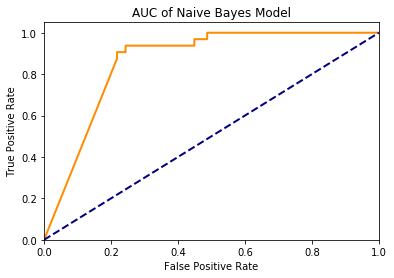

[1.61759760e-107 6.30280819e-106 9.11688493e-104 3.40493779e-097
 1.03882909e-093 6.39266506e-089 1.32323462e-084 1.70404956e-082
 7.88979168e-081 4.63575404e-077 1.13808426e-076 7.27718963e-071
 3.28529097e-069 4.46322595e-057 2.61892433e-055 3.53195860e-055
 1.68095186e-051 1.54419856e-047 2.18678155e-039 7.75841033e-038
 1.77137181e-009 9.99674488e-001 9.99999735e-001 1.00000000e+000
 1.00000000e+000 1.00000000e+000]


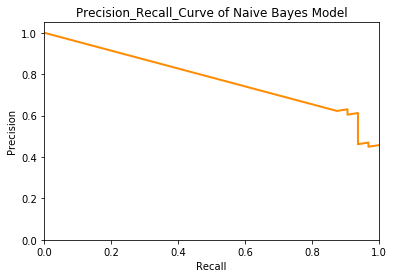

In [123]:
X_text = df_vec_conc.drop('spam/ham', axis=1).values
y_label = df_vec_conc.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X_text, y_label, test_size=0.2, random_state=40)
# train a multinomial naive Bayes model using the testing data
clf = MultinomialNB().fit(X_train, y_train)
print(clf)

predicted=clf.predict(X_test)


labels=sorted(df["spam"].unique())

precision, recall, fscore, support=\
     precision_recall_fscore_support(\
     y_test, predicted, labels=labels)

print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

# another way to get all performance metrics
print(classification_report(y_test, predicted, labels=labels))

# We need to get probabilities as predictions
predict_p=clf.predict_proba(X_test)

labels
# this label corresponds to last column
y_pred = predict_p[:,1]

# compute fpr/tpr by different thresholds
# positive class has label "1"
fpr, tpr, thresholds = roc_curve(y_test, y_pred, \
                                 pos_label=1)
# calculate auc
auc(fpr, tpr)
##plot:
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Naive Bayes Model');
plt.show();
# compute precision/recall by different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, \
                                y_pred, pos_label=1)
print(thresholds)
plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of Naive Bayes Model');
plt.show();

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
text_clf = Pipeline('clf', MultinomialNB())

parameters = {'clf__alpha': [0.5,1.0,2.0]}

# the metric used to select the best parameters
metric =  "f1_macro"

# GridSearch also uses cross validation
gs_clf = GridSearchCV\
(text_clf, param_grid=parameters, \
 scoring=metric, cv=5)

# due to data volume and large parameter combinations
# it may take long time to search for optimal parameter combination
# you can use a subset of data to test
gs_clf = gs_clf.fit(data["text"], data["label"])
print(gs_clf)

- After reducing dimensions, we campare data set from 3 different people. In #wzx, the distribution of spam and ham seems more similar. The distribution in #jsj are more similar with the distribution in #wzx. Because both #jsj and #wzx used Stevens mailbox, there are more same email and most of email are about job and Stevens.  

# EDA

In [61]:
def barplot_word(ham_word,spam_word):
    df_spam = pd.DataFrame(spam_word)
    df_spam.columns = ['word', 'count']
    df_ham = pd.DataFrame(ham_word)
    df_ham.columns = ['word', 'count']
    plt.figure(figsize=(20,12))
    plt.subplot(1, 2, 1)
    bar= sns.barplot(df_spam['word'][:20], df_spam['count'][:20], data=df_spam,palette="BuPu_r")
    plt.ylabel('word')
    plt.ylabel('count')
    for item in bar.get_xticklabels():
        item.set_rotation(90)
    for p in bar.patches:
                 bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')
    plt.title('Top 20 words for spam')

    plt.subplot(1, 2, 2)
    bar= sns.barplot(df_ham['word'][:20], df_ham['count'][:20], data=df_ham,palette="BuPu_r")
    plt.ylabel('word')
    plt.ylabel('count')
    for item in bar.get_xticklabels():
        item.set_rotation(90)
    for p in bar.patches:
                 bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')
    plt.title('Top 20 words for ham')
    plt.show()

In [62]:
def wordcloud_word(text_spam,text_ham):
    plt.figure(figsize=(32,32))

    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(text_spam)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('label_spam',fontsize=20)

    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(text_ham)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('label_ham',fontsize=20)
    plt.show()

In [63]:
def pie_word(df_ham,df_spam,group,by):
    df_spam_email = df_spam.groupby([group]).count().sort_values(by=[by],ascending=False)
    df_ham_email = df_ham.groupby([group]).count().sort_values(by=[by],ascending=False)
    labels_s = list(df_spam_email.index)
    sizes_s = df_spam_email.spam
    labels_h = list(df_ham_email.index)
    sizes_h = df_ham_email.spam

    fig1, ax1 = plt.subplots(1,2,figsize=(32,32))
    ax1[0].pie(sizes_s, labels=labels_s, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1[0].axis('off') 
    ax1[1].pie(sizes_h, labels=labels_h, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1[1].axis('off') 
    ax1[0].set_title('Sources of Spam',fontsize=20)
    ax1[1].set_title('Sources of Ham',fontsize=20)
    fig1.subplots_adjust(wspace=0.3)
    plt.show()

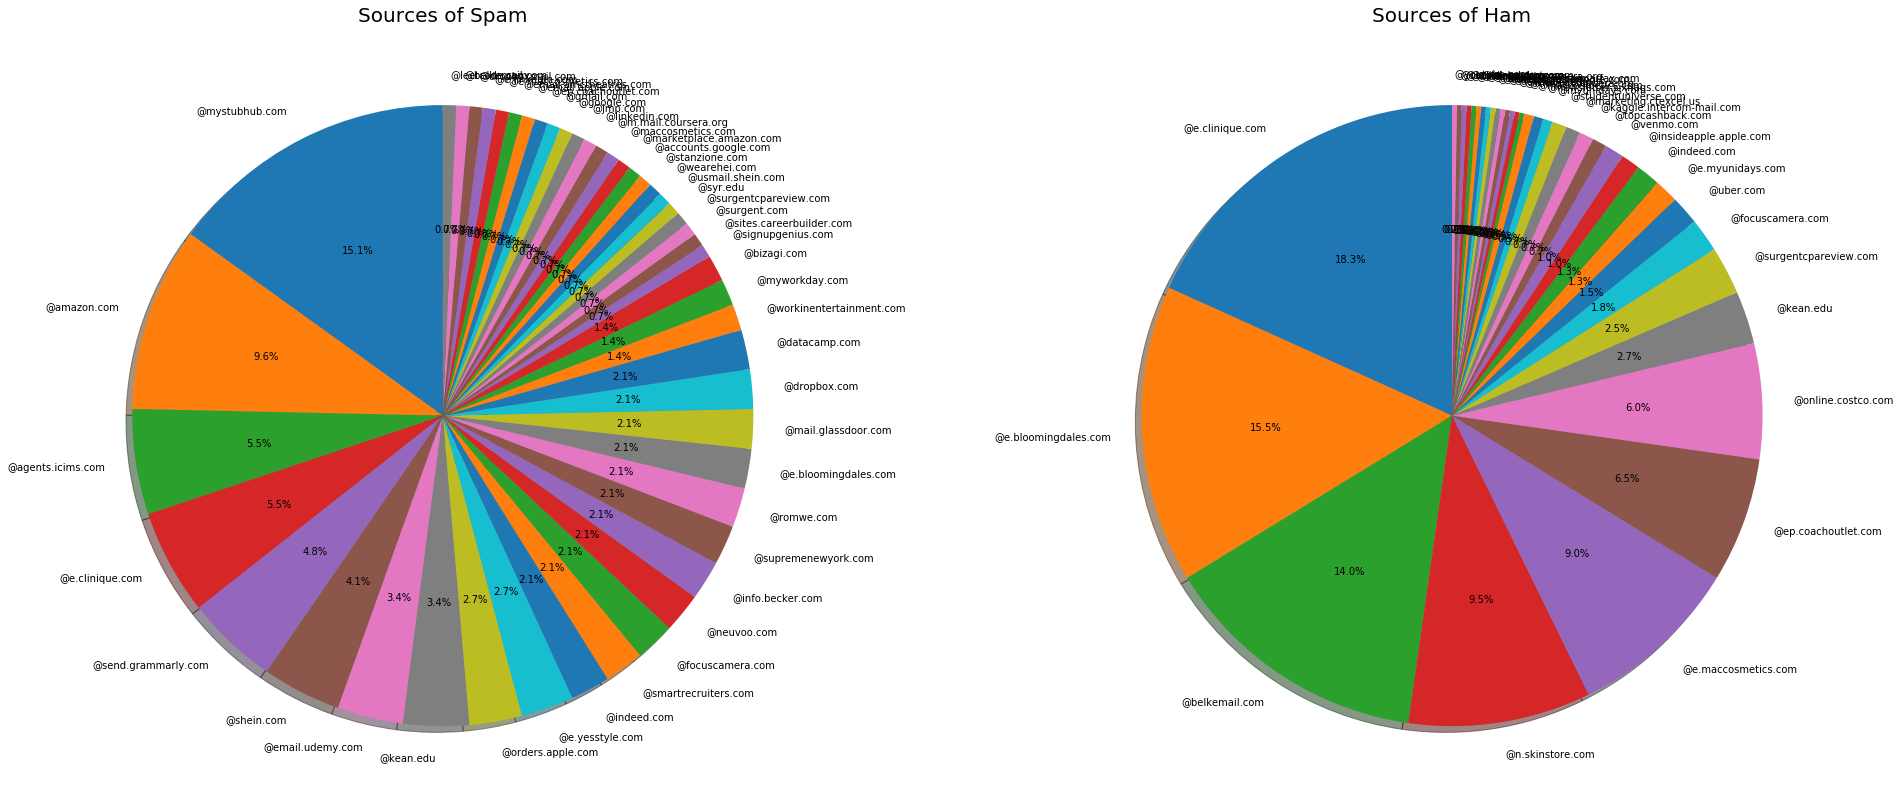

In [64]:
pie_word(df_ham,df_spam,'suffix','spam')

In [65]:
word_catogory = catogory_count(count_s.keys(),count_s.values(),count_h.keys(),count_h.values())
#All of word sorted
all_word = sort_word(word_catogory)
# Spam word sorted
spam_word = sort_word(word_catogory,True)
# Ham word sorted
ham_word = sort_word(word_catogory,False)

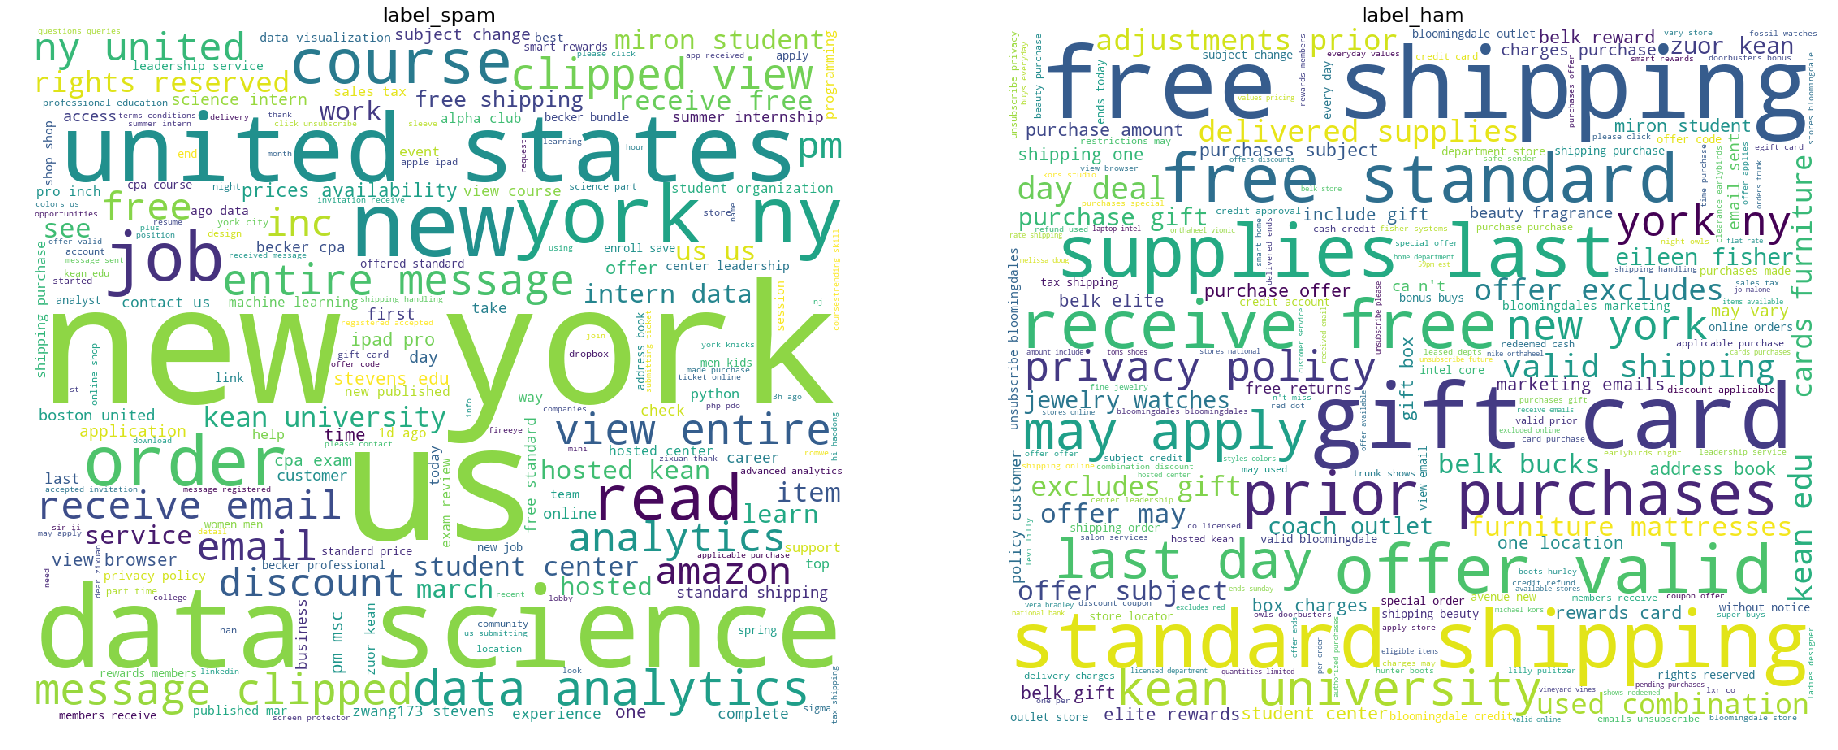

In [66]:
wordcloud_word(text_spam,text_ham)

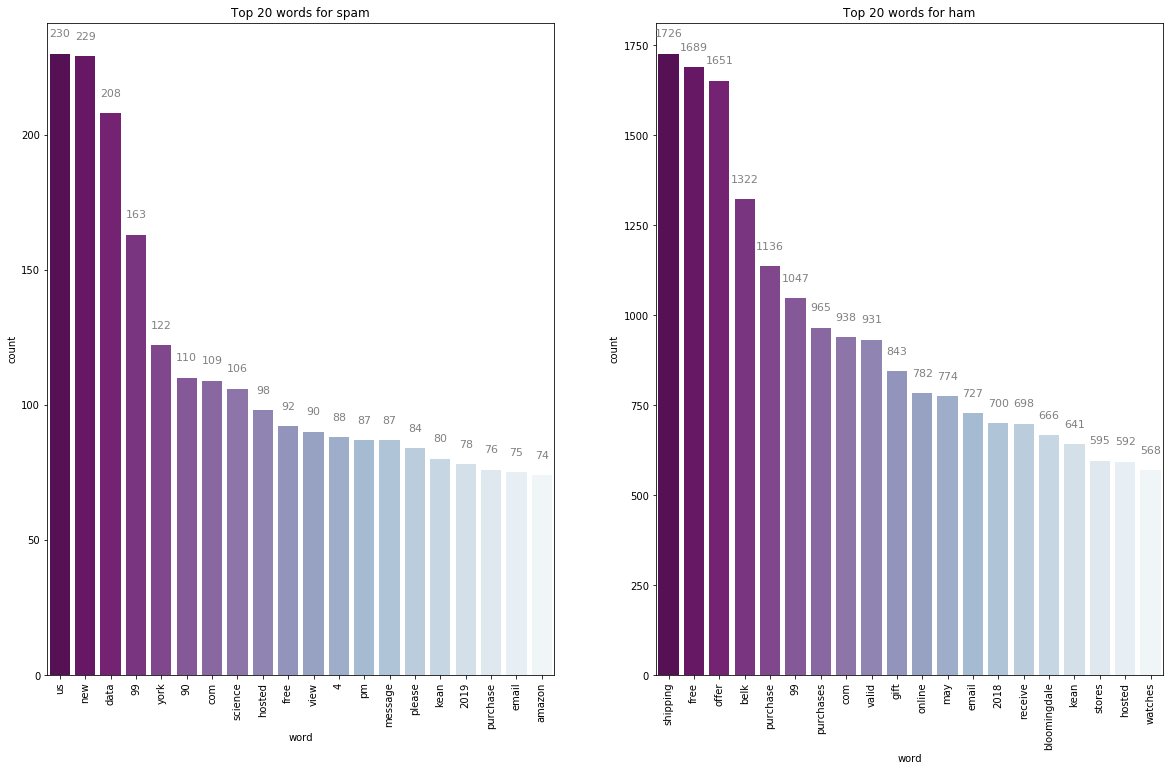

In [67]:
barplot_word(ham_word,spam_word)

In [73]:
for i in range(len(data_s)):
    data_h[i] = re.sub(r'\b(new|york|data|us|99|kean|university|standard|shipping|zuor|edu|purchase|message)\b', '', data_h[i])
    data_s[i] = re.sub(r'\b(new|york|data|us|99|kean|university|standard|shipping|zuor|edu|purchase|message)\b', '', data_s[i]) 
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
count_s = count(word_s)
count_h = count(word_h)
word_catogory = catogory_count(count_s.keys(),count_s.values(),count_h.keys(),count_h.values())
#All of word sorted
all_word = sort_word(word_catogory)
# Spam word sorted
spam_word = sort_word(word_catogory,True)
# Ham word sorted
ham_word = sort_word(word_catogory,False)

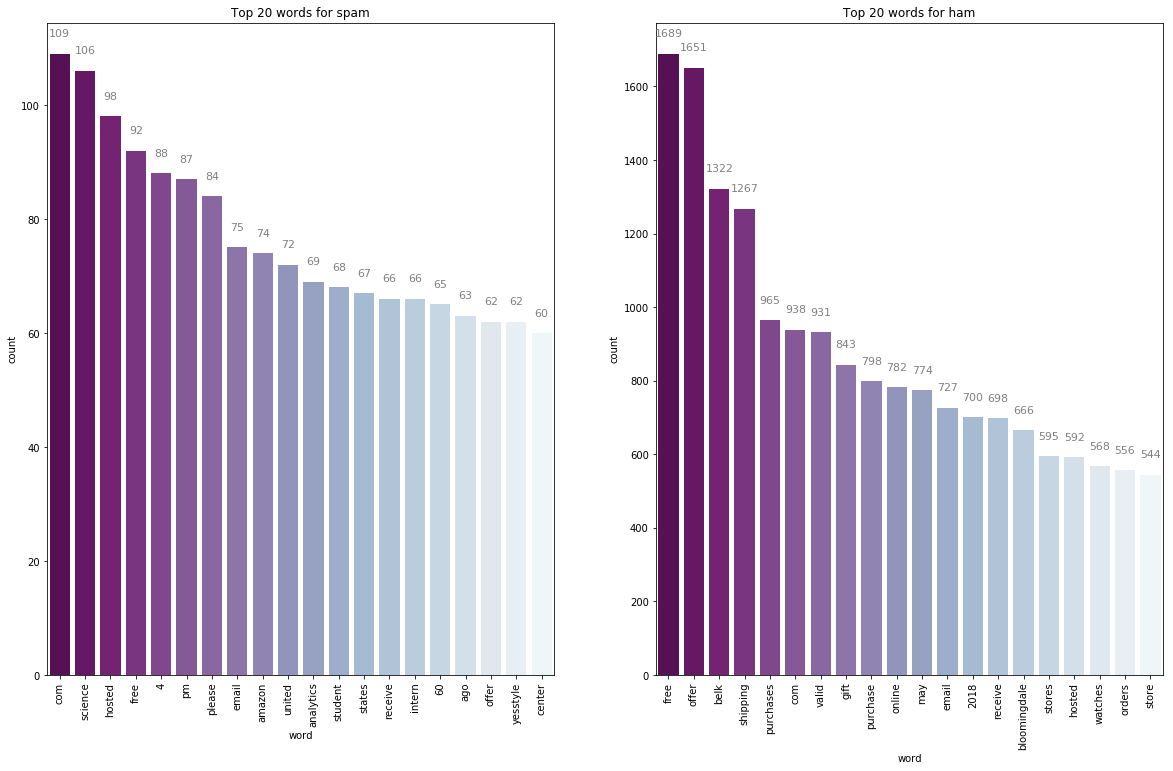

In [74]:
barplot_word(ham_word,spam_word)

In [77]:
text_spam = re.sub(r'\b(new|york|data|us|99|kean|university|standard|shipping|zuor|edu|purchase|message|united|states)\b', '', text_spam)
text_ham = re.sub(r'\b(new|york|data|us|99|kean|university|standard|shipping|zuor|edu|purchase|message)\b', '', text_ham)

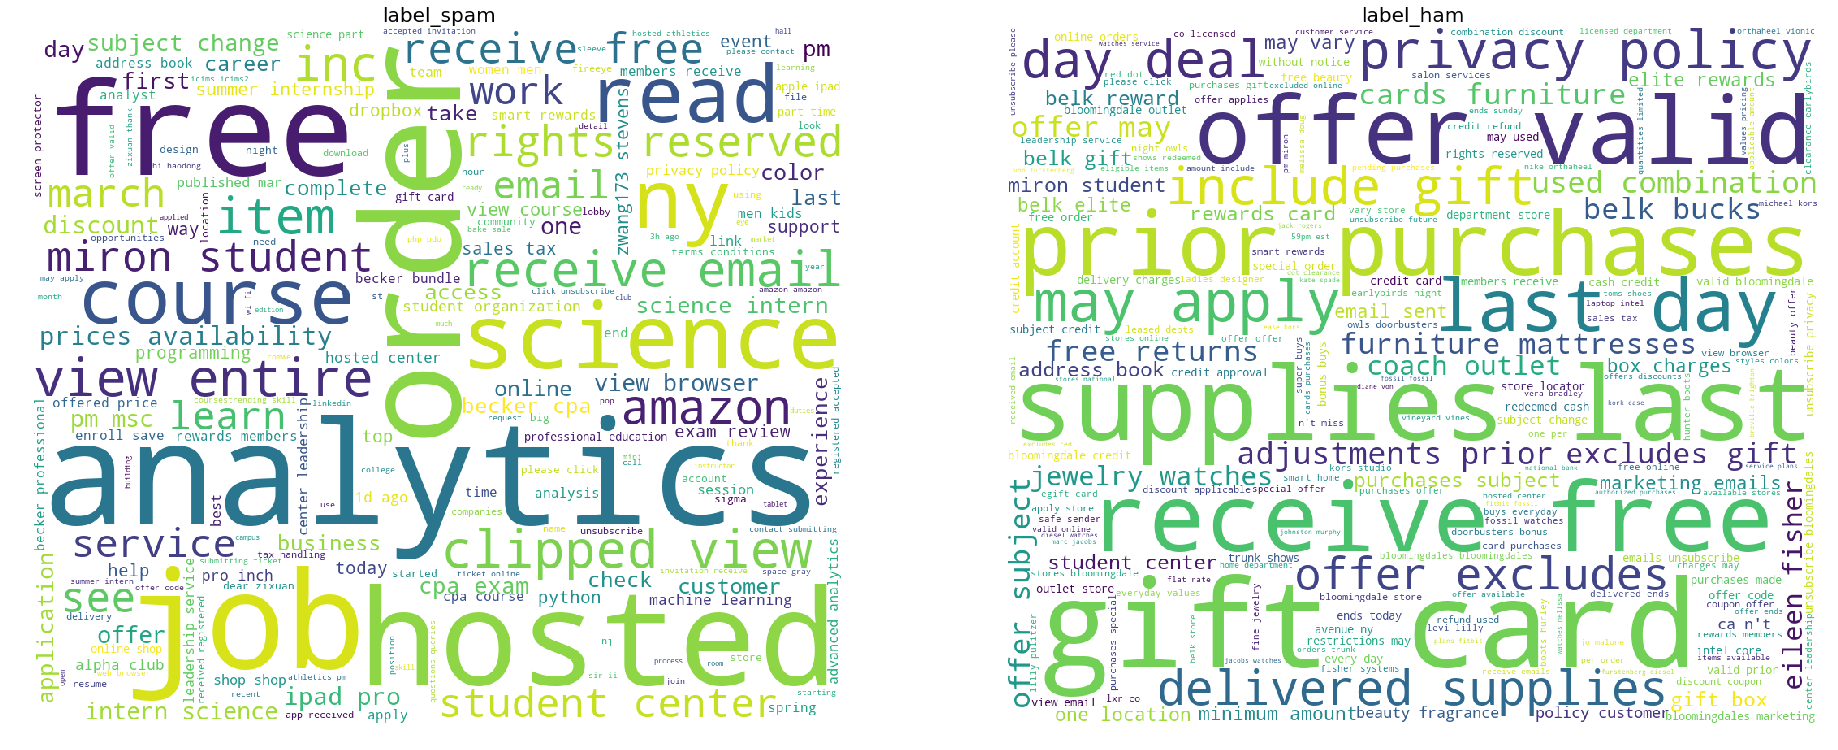

In [78]:
wordcloud_word(text_spam,text_ham)

In [200]:
df = df[df.suffix != '@linkedin.com']
idx_rdm_ham = random.sample(list(df[df.spam == 0].index),196)
idx_rdm_ham.sort()
df_ham = df.loc[idx_rdm_ham,]
df_spam = df[df.spam == 1]
data_title_s = list(df_spam[df_spam.spam == 1].title)
data_content_s = list(df_spam[df_spam.spam == 1].content)
data_title_h = list(df_ham[df_ham.spam == 0].title)
data_content_h = list(df_ham[df_ham.spam == 0].content)
# data_title_s = [x[2] for x in data_s]
# data_content_s = [x[3] for x in data_s]
# data_title_h = [x[2] for x in data_h]
# data_content_h = [x[3] for x in data_h]
# data_s = [x + ' ' + y for x,y in zip(data_title_s,data_content_s)]
# data_h = [x + ' ' + y for x,y in zip(data_title_h,data_content_h)]
sample_content_s = [tokenize(x,lemma = False, stopword = True) for x in data_content_s]
sample_content_h = [tokenize(x,lemma = False, stopword = True) for x in data_content_h]
sample_title_s = [tokenize(x,lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(x,lemma = False, stopword = True) for x in data_title_h]
sample_s = [x + y for x,y in zip(sample_title_s,sample_content_s)]
sample_h = [x + y for x,y in zip(sample_title_h,sample_content_h)]
data_s = [' '.join(i) for i in sample_s]
data_h = [' '.join(i) for i in sample_h]
text_spam = ' '.join([' '.join(i) for i in sample_s])
text_ham = ' '.join([' '.join(i) for i in sample_h])
# title_word_s = text_lst(data_title_s)
# content_word_s = text_lst(data_content_s)
# title_word_h = text_lst(data_title_h)
# content_word_h = text_lst(data_content_h)
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
# title_count_s = count(title_word_s)
# content_count_s = count(content_word_s)
# title_count_h = count(title_word_h)
# content_count_h = count(content_word_h)
count_s = count(word_s)
count_h = count(word_h)

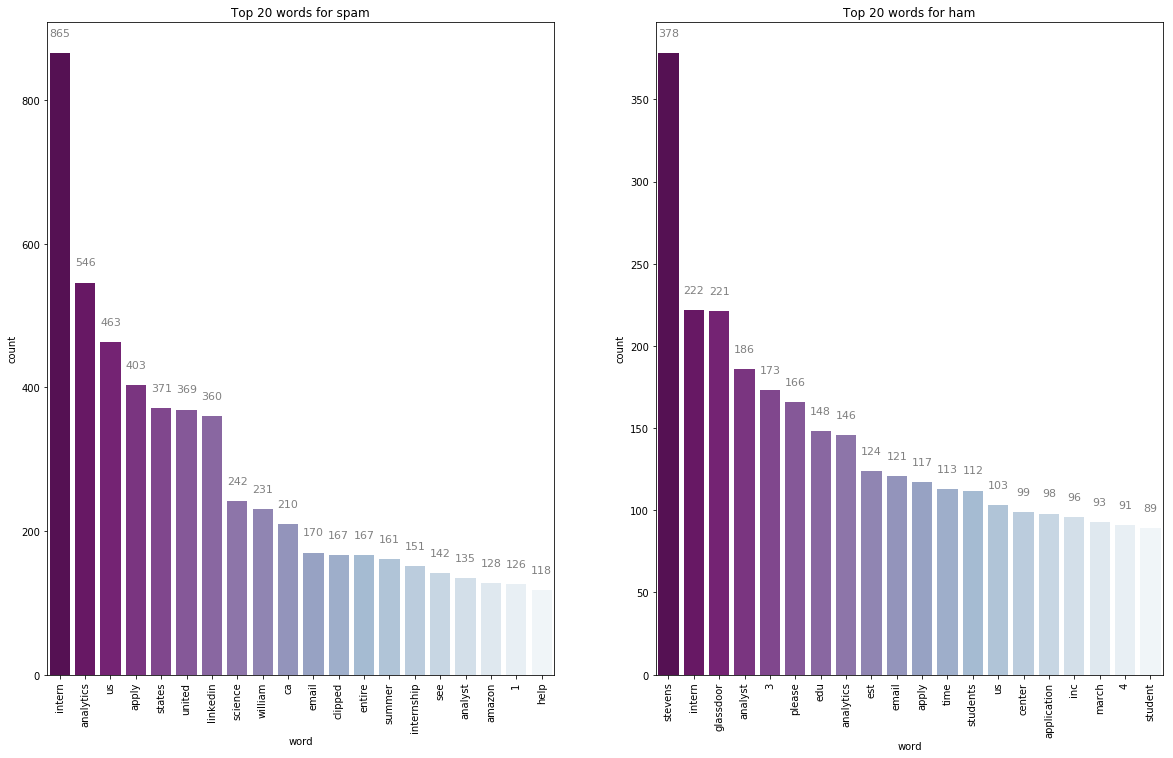

In [201]:
barplot_word(ham_word,spam_word)

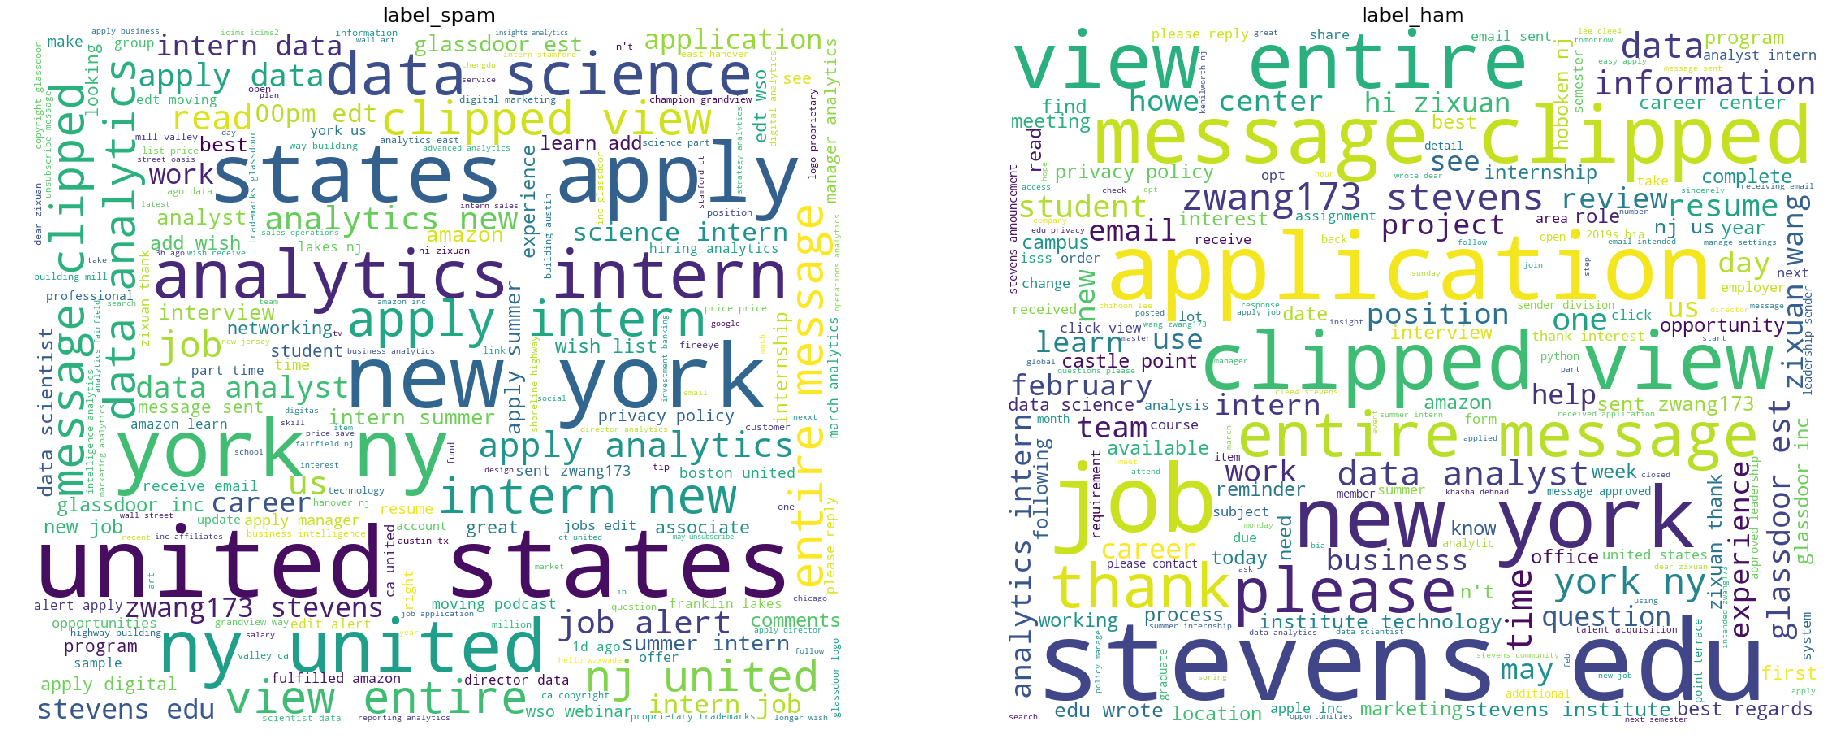

In [202]:
wordcloud_word(text_spam,text_ham)